In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

In [3]:
df = pd.read_csv('trump_tweets.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by='date').reset_index(drop=True)
df = df.rename(columns={"favorites":"likes"})
df['month'] = df.date.apply(lambda x: x.month)
df['year'] = df.date.apply(lambda x: x.year)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        56571 non-null  int64         
 1   text      56571 non-null  object        
 2   device    56571 non-null  object        
 3   likes     56571 non-null  int64         
 4   retweets  56571 non-null  int64         
 5   date      56571 non-null  datetime64[ns]
 6   month     56571 non-null  int64         
 7   year      56571 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 3.5+ MB
None


In [4]:
# Cleaning Functions

def split_ampersands(input_string):
    split = input_string.split('&')
    output = ''
    for item in split:
        output += item +'& '
    return output[:-2]

def white_space_remover(input_df):
    while input_df.text.apply(lambda x: '  ' in x).sum() > 0:
        input_df.text = input_df.text.apply(lambda x: x.replace('  ', ' '))

def hyperlink_remover(input_text):
    t = input_text.split()
    output_string = ""
    for word in t:
        if "http" in word:
            start=word.find("http")
            s = " " + word[:start]
            output_string += s
            output_string = output_string.strip()
        else:
            output_string += (" " + word)
            output_string = output_string.strip()
    return output_string

def is_retweet(input_string):
    return input_string[:2] == 'RT'

def blanker(input_string, condition = False):
    if condition:
        return ''
    else:
        return input_string

In [5]:
# Full Clean

def text_cleaner(input_df, drop_rt = False, drop_quote = False):
    output_df = input_df.copy()
    
    # Clean up HTML escape characters
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&amp;', '&')).apply(lambda x: x.replace('&amp','&'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&,', '&')).apply(lambda x: x.replace('&,', '&'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&…', '...')).apply(lambda x: x.replace('&...', '...'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&gt;', '>')).apply(lambda x: x.replace('&gt','>'))
    output_df['text'] = output_df.text.apply(lambda x: x.replace('&lt;', '<')).apply(lambda x: x.replace('&lt','<'))
    
    # Fix ampersands
    output_df['text'] = output_df.text.apply(lambda x: split_ampersands(x)) 
    white_space_remover(output_df)
    
    # Fix verified @'s
    output_df['text'] = output_df.text.apply(lambda x: x.replace('.@','@'))
    
    # Fix annoying elipses
    output_df['text'] = output_df.text.apply(lambda x: x.replace('…', '...'))
    
    # Clean out new line characters
    while output_df.text.apply(lambda x: ' \n' in x).sum() >0 :
        output_df['text'] = output_df.text.apply(lambda x: x.replace(' \n', '. '))
        white_space_remover(output_df)
    
    while output_df.text.apply(lambda x: '\n' in x).sum() > 0:
        output_df['text'] = output_df.text.apply(lambda x: x.replace('\n', '. '))
        white_space_remover(output_df)
    
    # Remove hyperlinks
    output_df['text'] = output_df.text.apply(lambda x: hyperlink_remover(x))
    white_space_remover(output_df)
    
    if drop_rt:
        output_df['text'] = output_df.text.apply(lambda x: blanker(x, is_retweet(x)))
    
    if drop_quote:
        output_df['text'] = output_df.text.apply(lambda x: blanker(x, is_quote(x)))
    
    # Clear out tweets that have been blanked
    output_df['text'] = output_df.text.apply(lambda x: x if ((len(str(x))>0) & (str(x)!='nan'))else np.nan)
    output_df.dropna(inplace=True)
    
    return output_df

In [6]:
def is_quote(input_string, debug=False):
    if debug: print(input_string)
    return (input_string[:3] == '"""')

def is_attribution(input_text):
    if input_text[:3] != '"""':
        return False
    if is_full_quote(input_text):
        return False
    attribution_flags = re.compile(r'"" -|""-|" -|"-|"" –|""–|" –|"–')
    result = attribution_flags.search(input_text)
    if result == None:
        return False
    else:
        return True

def is_quote_reply(input_text, debug=False):
    if input_text[:3] != '"""':
        if debug: print('Start not triple quote')
        return False
    if input_text[-1] != '"':
        if debug: print('End not quote')
        return False
    if input_text[-3:] == '"""':
        if debug: print('End not triple quote')
        return False
    if is_attribution(input_text):
        if debug: print('is attribution')
        return False
    flags = re.compile(r'[^"]""[^"]')
    result = flags.search(input_text)
    if result == None:
        if debug: print('double quote not found')
        return False
    else:
        return True
    
def is_full_quote(input_text):
    if input_text[:3] == '"""' and input_text[-3:] == '"""':
        return True
    else:
        return False 

def is_remainder(input_text):
    return not (is_attribution(input_text) | is_quote_reply(input_text) | is_full_quote(input_text))

In [7]:
# Tokenizer Functions

QS = '<QS>' # quote start
QE = '<QE>' # quote end
RS = '<RS>' # reply start
RE = '<RE>' # reply end
RT = '<RT>' # retweet
AT = '<AT>' # @ mentions

def quote_tokenizer(input_text):
    if is_quote(input_text):
        output_text = ''
        if is_full_quote(input_text):
            while input_text[-1] == '"':
                input_text = input_text[:-1]
            output_text = QS + '"' + input_text[3:] + '"' + QE
            return output_text
        if is_quote_reply(input_text):
            end_quote = input_text[3:].rindex('""')
            assert end_quote > 0, 'improper reply'
            output_text = QS + '"' + input_text[3:end_quote] + '"' + QE+RS+input_text[end_quote+2:-1]+RE
            return output_text
    return input_text

def rt_tokenizer(input_text):
    if is_retweet(input_text):
        return RT+input_text[2:]
    return input_text

def double_quote_cleaner(input_text):
    output_text = input_text
    while '""' in output_text:
        output_text = output_text.replace('""', '"')
    return output_text

def at_tokenizer(input_text):
    return input_text.replace('@', '<AT>@')

In [8]:
def tokenize(output_df):
    output_df = output_df.copy()
    
    # Remove quotes that aren't categorized (e.g. not full quotes, quote-replies)
    output_df['text'] = output_df[output_df.text.apply(lambda x: not (is_quote(x) & is_remainder(x)))]['text']
    output_df = output_df.dropna()
    output_df['text'] = output_df.text.apply(lambda x: quote_tokenizer(x))
    output_df['text'] = output_df.text.apply(lambda x: rt_tokenizer(x))
    output_df['text'] = output_df.text.apply(lambda x: double_quote_cleaner(x))
    output_df['text'] = output_df.text.apply(lambda x: at_tokenizer(x))
    
    return output_df

In [9]:
# Joining 'Threads' together

def possible_thread(input_string):
    return '..' in input_string[-2:]

def possible_continuation(input_string):
    return '..' in input_string[:2] and '..' in input_string[-2]

def possible_end(input_string):
    return '..' in input_string[:2]
                                                             

def period_remover(input_string, operation):
    s = input_string
    if operation == 'start': 
        while s[-1] == ('.' or '…'):
            s = s[:-1]
        s = s+" "
    if operation == 'middle':
        while s[0] == ('.' or '…'):
            s = s[1:]
        while s[-1] == ('.' or '…'):
            s = s[:-1]
        s = s+" "
    if operation == 'end':
        while s[0] == '.':
            s = s[1:]
    return s

# Didn't build it to handle the last element ending in '..'
def thread_joiner(input_df):
    joined_threads = []
    output_df = input_df.copy()
    
    output_df['start_thread'] = output_df.text.apply(lambda x: possible_thread(x)) # True/False
    output_df['cont_thread'] = output_df.text.apply(lambda x: possible_continuation(x)) # True/False
    output_df['end_thread'] = output_df.text.apply(lambda x: possible_end(x)) # True/False
    output_df['flag'] = False
    
    for i in range(len(output_df)):
        if output_df.iloc[i]['start_thread'] and \
        (output_df.iloc[i+1]['cont_thread'] or output_df.iloc[i+1]['end_thread']):
            text = period_remover(output_df.iloc[i]['text'], 'start')
            j = i+1
            while output_df.iloc[j]['cont_thread']:
                j+=1
                output_df.iloc[j,-1] = True
            for k in range(i+1, j):
                text += period_remover(output_df.iloc[k]['text'], 'middle')
                output_df.iloc[k,-1] = True
            output_df.iloc[j,-1] = True
            text += period_remover(output_df.iloc[j]['text'], 'end')
            
            
            output_df.iloc[i,0] = text
            joined_threads.append(text)
    output_df = output_df.drop(output_df[output_df['flag']==True].index)
    output_df = output_df.drop(['start_thread', 'cont_thread','end_thread', 'flag'], axis=1)
    output_df = output_df.dropna()
    output_df = output_df.reset_index(drop=True)
    return output_df, joined_threads         
    

In [10]:
clean_df = text_cleaner(df)
clean_df, joined_thread_record = thread_joiner(clean_df)
clean_df = tokenize(clean_df)
print(f'{len(df)-len(clean_df)} of {len(df)} records removed.')
print(f'{len(clean_df)} record remain.')

4906 of 56571 records removed.
51665 record remain.


## No significant loss in a given time period.

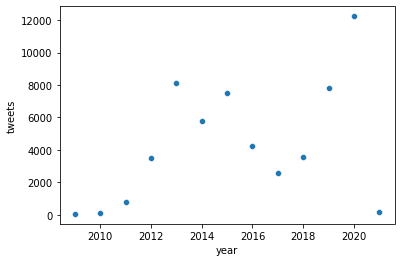

In [15]:
tweets_per_year = df.groupby('year').agg('count')['id']
_ = sns.scatterplot(data=tweets_per_year)
plt.ylabel('tweets')
plt.show()

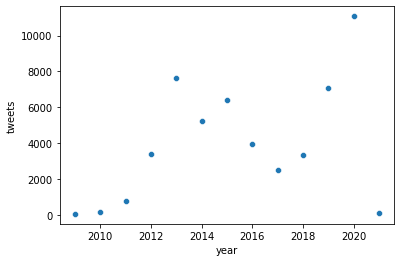

In [16]:
tweets_per_year = clean_df.groupby('year').agg('count')['id']
_ = sns.scatterplot(data=tweets_per_year)
plt.ylabel('tweets')
plt.show()

In [19]:
clean_df.to_csv('tokenized_clean_tweets.csv',index=False)

In [15]:
# Untokenized Tweets for some EDA.
untokenized_df = text_cleaner(df)
untokenized_df, _ = thread_joiner(untokenized_df)
untokenized_df = untokenized_df.dropna()
untokenized_df.to_csv('untokenized_df.csv', index=False)

In [17]:
# Tweets from the 'presidential' era
clean_df[clean_df.year >= 2015].to_csv('tokenized_clean_tweets_recent.csv', index=False)

In [18]:
# recent, no quotes/RT

recent_raw = text_cleaner(df, True, True)
recent_raw, _ = thread_joiner(recent_raw)
recent_raw = recent_raw.dropna()
recent_raw[recent_raw.year >= 2015].to_csv('recent_raw_tweets.csv', index=False)
